In [1]:
import pickle

import matplotlib.pyplot as plt
from matplotlib import collections as mc
import numpy as np
import sklearn
from sklearn import linear_model
import torch

import os
os.chdir('..')

from latent_actions import cvae
from latent_actions.data.dataset import EpisodicDataset
from panda_gym.pybullet import PyBullet
from panda_gym.envs.robots.panda import Panda

/Users/shivampatel/miniconda3/envs/la/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: Aug 21 2022 17:44:27


In [2]:
with open('data/rpnp_traj_final.pkl', 'rb') as fp:
    epi_ds = pickle.load(fp)

In [3]:
def visualize_encoder(decoder):
    actions_joints_test = np.array([np.hstack([step.joint_velocity, np.array([step.gripper_velocity]), step.context['joint_angles'], np.array([step.context['gripper_width']])]) for epi in epi_ds.episodes for step in epi.steps])  
    actions_joints_test = actions_joints_test.reshape(actions_joints_test.shape[0], -1)

    x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
    mu = decoder.fc_mu(x).detach().numpy()
    log_var = decoder.fc_var(x)
    std = torch.exp(log_var / 2).detach().numpy()

    std_x = std.copy()
    std_x[:, 1] = 0
    std_y = std.copy()
    std_y[:, 0] = 0

    horizontal_lines = list(zip(mu-std_x, mu+std_x))
    vertical_lines = list(zip(mu-std_y, mu+std_y))

    hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
    vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.add_collection(hlc)
    ax.add_collection(vlc)
    ax.autoscale()
    ax.margins(0.1)
    ax.scatter(mu[:, 0], mu[:, 1])
    ax.set_title('mean and variance of encoder')
    
    plt.show()

In [4]:
def get_latent_bounds(decoder):
    actions_joints_test = np.array([np.hstack([step.joint_velocity, np.array([step.gripper_velocity]), step.context['joint_angles'], np.array([step.context['gripper_width']])]) for epi in epi_ds.episodes for step in epi.steps])  
    actions_joints_test = actions_joints_test.reshape(actions_joints_test.shape[0], -1)

    x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
    mu = decoder.fc_mu(x).detach().numpy()
    log_var = decoder.fc_var(x)
    std = torch.exp(log_var / 2).detach().numpy()

    return {
        'x_min': min((mu - std)[:, 0]), 
        'x_max': max((mu + std)[:, 0]), 
        'y_min': min((mu - std)[:, 1]), 
        'y_max': max((mu + std)[:, 1])}

In [5]:
joint_angles_at_goals = np.array([[ 1.44588306e-01,  1.56268346e-01,  8.07866432e-02, -2.22773083e+00,
        -1.82527290e-02,  2.38333390e+00,  1.02300393e+00, 0.08],
        [ 1.19207576e-01,  4.28402138e-01,  4.35761332e-02, -1.82187401e+00,
        -2.32348485e-02,  2.24982594e+00,  9.58834546e-01, 0.08],
        [ 1.52117856e-01,  7.97187831e-01,  3.49613257e-02, -1.21386862e+00,
        -2.76501959e-02,  2.01099579e+00,  9.73732990e-01,  0.08],
        [-7.52278690e-04,  1.41666620e-01,  7.54507637e-04, -2.24740225e+00,
        -1.59707497e-04,  2.38893706e+00,  7.85508406e-01,  0.08],
        [0.  ,  0.41,  0.  , -1.85,  0.  ,  2.26,  0.7, 0.08],
        [-4.32464727e-04,  7.34278866e-01,  4.17566266e-04, -1.32124125e+00,
        -3.23125398e-04,  2.05588736e+00,  7.85434240e-01,  0.08],
        [-1.46284674e-01,  1.56262482e-01, -7.92358201e-02, -2.22769468e+00,
         1.79012298e-02,  2.38331457e+00,  5.47884896e-01,  0.08],
        [-1.20440644e-01,  4.28401221e-01, -4.24080733e-02, -1.82187385e+00,
         2.26049099e-02,  2.24985028e+00,  6.12198992e-01,  0.08],
        [-1.52763609e-01,  7.97160658e-01, -3.43718665e-02, -1.21390903e+00,
         2.71685161e-02,  2.01102450e+00,  5.97050070e-01,  0.08]])

In [7]:
def visualize_decoder(decoder, x_min, x_max, y_min, y_max, subtract_neutral_from_context = False):
    x, y = np.meshgrid(
        np.arange(x_min, x_max, (x_max - x_min) / 20), 
        np.arange(y_min, y_max, (y_max - y_min) / 20))
    latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)

    fig, axs = plt.subplots(3, 3, figsize=(20, 7))
    

    for i, joint_angles in enumerate(joint_angles_at_goals):

        contexts = torch.tensor(np.stack([joint_angles] * latents.shape[0]), dtype=torch.float)
        if subtract_neutral_from_context:
            contexts -= torch.tensor(neutral_joint_angles[:8])
        actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
        axs[i // 3, i % 3].imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
        axs[i // 3, i % 3].set_title(i)

#     contexts = torch.tensor(np.stack([neutral_joint_angles[:7]] * latents.shape[0]), dtype=torch.float)
#     if subtract_neutral_from_context:
#         contexts -= torch.tensor(neutral_joint_angles[:7])
#     actions_joints = decoder(latent=latents, context=contexts).detach().numpy()
#     axs[1, 1].imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))

In [8]:
sim = PyBullet(render=False)
robot = Panda(sim=sim, control_type='joints')

In [9]:
def visualize_decoder_forward_kinematics(decoder, x_min, x_max, y_min, y_max, subtract_neutral_from_context = False):
    x, y = np.meshgrid(
        np.arange(x_min, x_max, (x_max - x_min) / 20), 
        np.arange(y_min, y_max, (y_max - y_min) / 20))
    latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 20))

    for i, joint_angles in enumerate(joint_angles_at_goals):

        contexts = torch.tensor(np.stack([joint_angles] * latents.shape[0]), dtype=torch.float)
        if subtract_neutral_from_context:
            contexts -= torch.tensor(neutral_joint_angles[:8])
        actions_joints = decoder(latent=latents, context=contexts).detach().numpy()

        actions_ee = []
        robot.set_joint_angles(joint_angles)
        current_ee_position = robot.get_ee_position()

        for action_joints in actions_joints:
            robot.set_action(action_joints)
            sim.step()
            actions_ee.append(robot.get_ee_position() - current_ee_position)
            robot.set_joint_angles(joint_angles)

        actions_ee = np.array(actions_ee)
        axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
        axs[i // 3, i % 3].set_title(i)

    actions_ee = []
    
    plt.show()

In [10]:
def offline_evaluation(decoder, subtract_neutral_from_context = False):
    fig = plt.figure(figsize=(10, 10))

    for episode in episodes[:30]:
        ee_positions_ground_truth = np.array(
            [step['previous_observation']['achieved_goal'] for step in episode])
        plt.scatter(ee_positions_ground_truth[:, 0], ee_positions_ground_truth[:, 1], color='r')

        obs = env.reset()

        ee_positions_predicted = []
        for step in episode:
            context = torch.tensor(step['previous_joint_angles'], dtype=torch.float)
            if subtract_neutral_from_context:
                context -= torch.tensor(neutral_joint_angles[:7])
            z = decoder.encoder(
                torch.cat((
                    torch.tensor(step['action_joints'], dtype=torch.float), 
                    context))).reshape(1, -1)
            z = decoder.fc_mu(z)
            joint_action = decoder(
                latent=z, 
                context=context.reshape(1, -1))
            obs, _, _, _ = env.step(joint_action.detach().numpy().squeeze())
            ee_positions_predicted.append(obs['achieved_goal'])

        ee_positions_predicted = np.array(ee_positions_predicted)
        plt.scatter(ee_positions_predicted[:, 0], ee_positions_predicted[:, 1], color='b')

    plt.show()

## test-training-checkpoint

In [10]:
decoder = cvae.ConditionalVAE.load_from_checkpoint('lightning_logs/version_9/checkpoints/epoch=4-step=1474.ckpt')

In [11]:
decoder

ConditionalVAE(
  (encoder): Sequential(
    (0): Linear(in_features=16, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=8, bias=True)
  )
  (fc_mu): Linear(in_features=10, out_features=2, bias=True)
  (fc_var): Linear(in_features=10, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

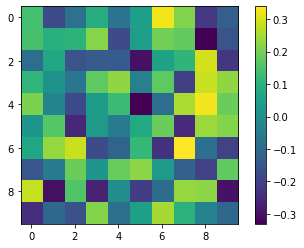

In [12]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

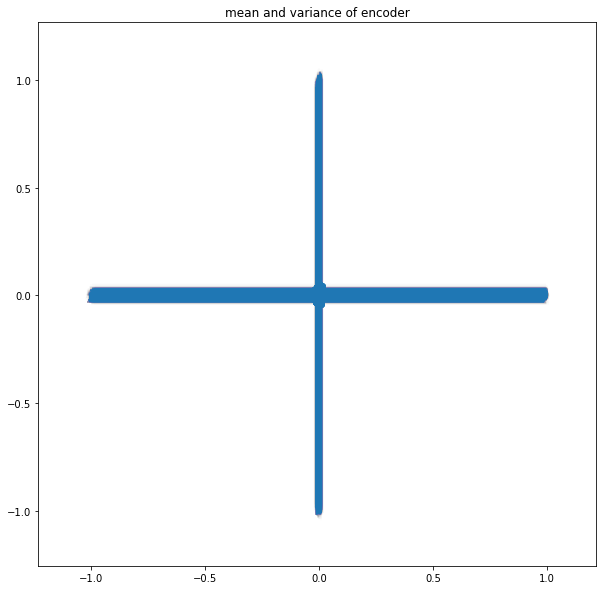

In [13]:
visualize_encoder(decoder)

{'x_min': -1.0283302, 'x_max': 1.0143391, 'y_min': -1.0443112, 'y_max': 1.0577989}


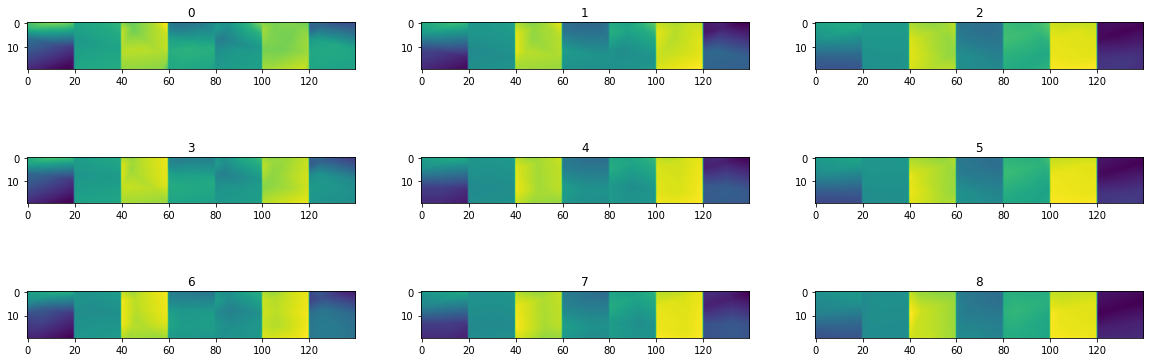

In [14]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

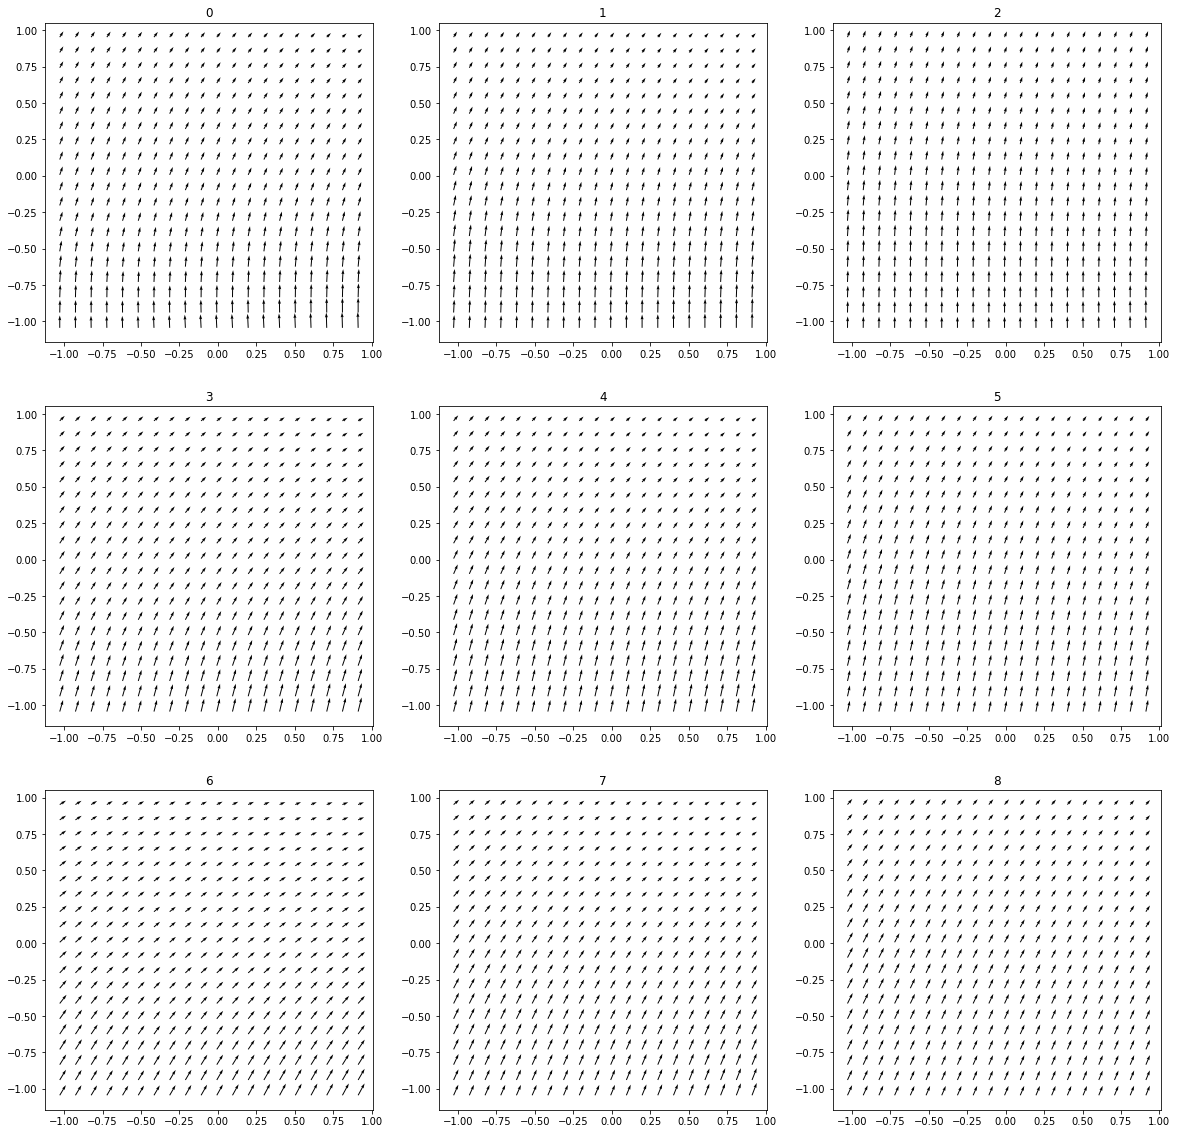

In [15]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

## VAE

In [16]:
decoder = cvae.ConditionalVAE.load_from_checkpoint('checkpoints/vae.ckpt')

In [17]:
decoder

ConditionalVAE(
  (encoder): Sequential(
    (0): Linear(in_features=16, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=8, bias=True)
  )
  (fc_mu): Linear(in_features=10, out_features=2, bias=True)
  (fc_var): Linear(in_features=10, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

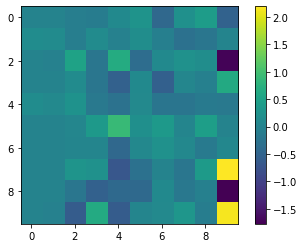

In [18]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

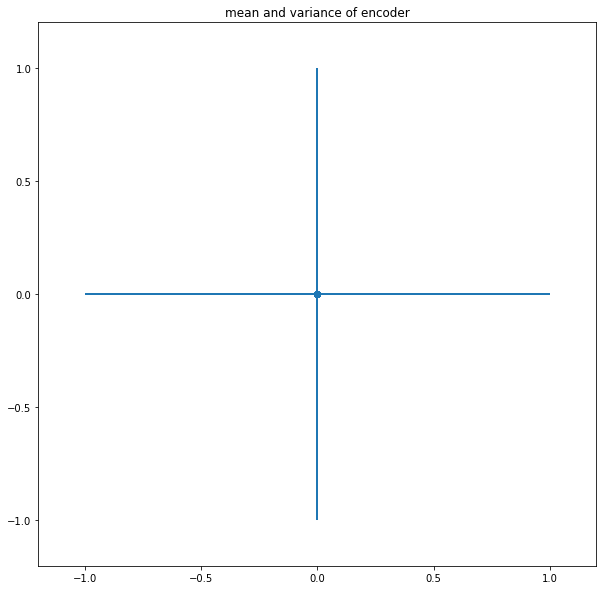

In [19]:
visualize_encoder(decoder)

{'x_min': -1.0003543, 'x_max': 1.0001442, 'y_min': -1.0003369, 'y_max': 1.0004348}


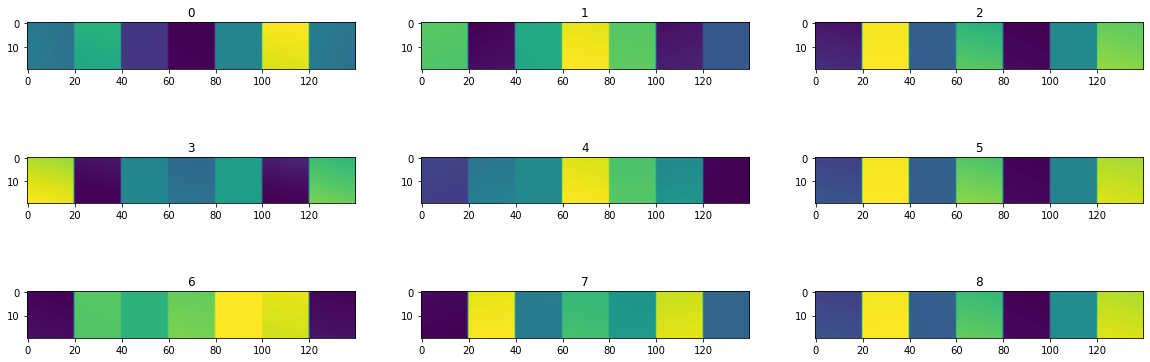

In [20]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

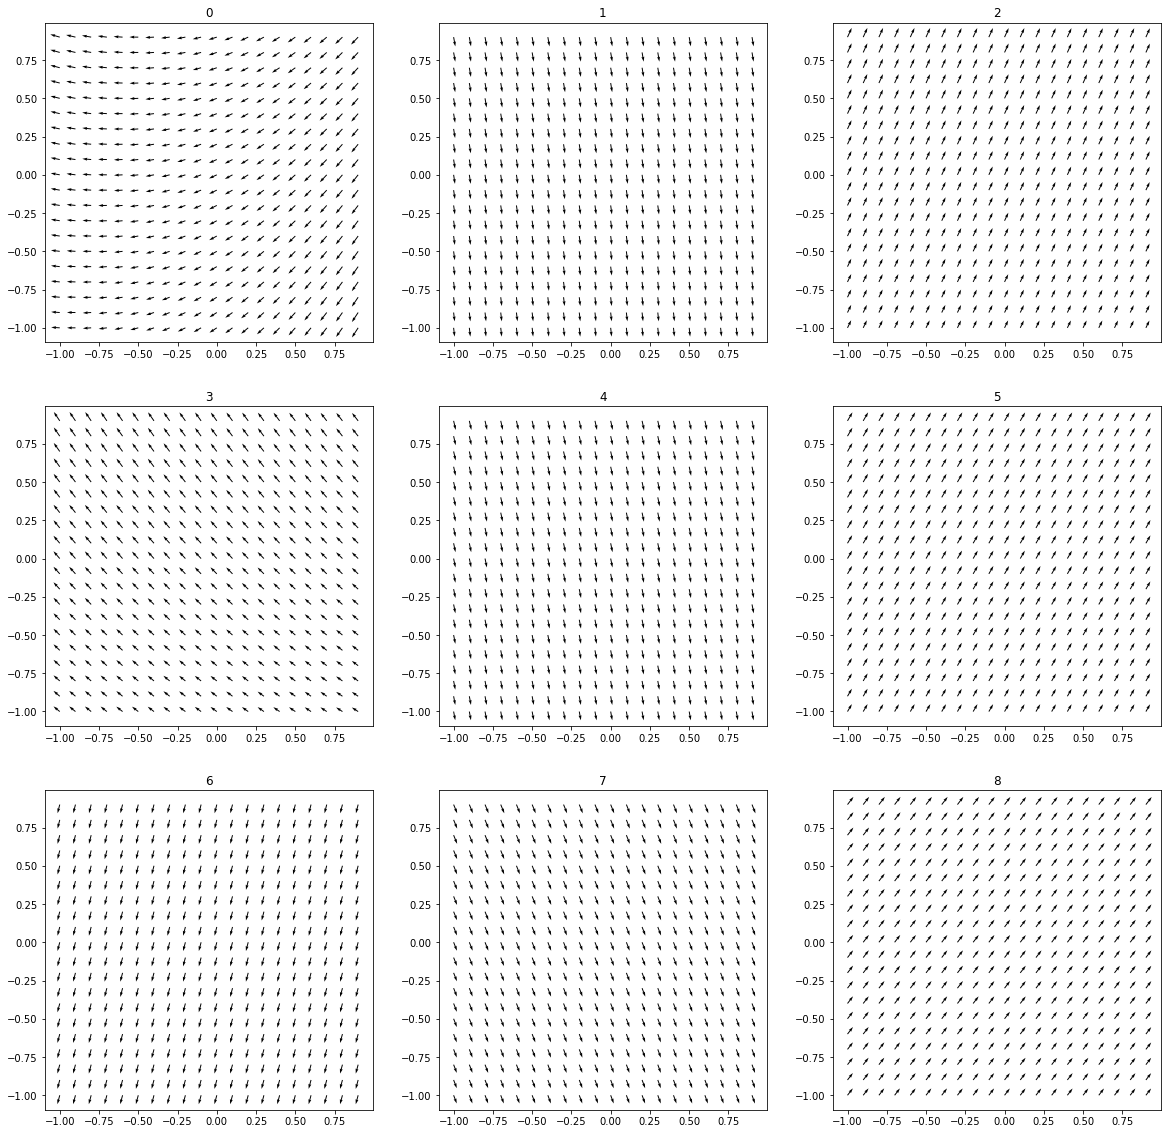

In [21]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

## VAE(0.1)

In [31]:
decoder = cvae.ConditionalVAE.load_from_checkpoint('checkpoints/vae-0.1.ckpt')

In [32]:
decoder

ConditionalVAE(
  (encoder): Sequential(
    (0): Linear(in_features=16, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=8, bias=True)
  )
  (fc_mu): Linear(in_features=10, out_features=2, bias=True)
  (fc_var): Linear(in_features=10, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

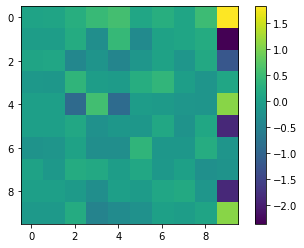

In [33]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

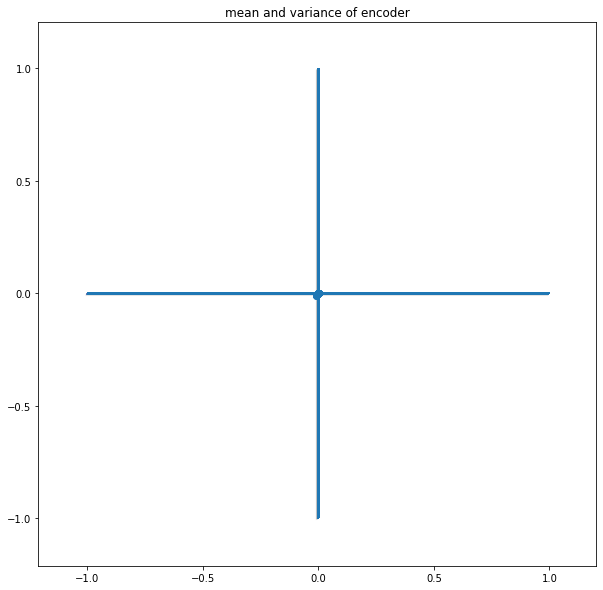

In [34]:
visualize_encoder(decoder)

{'x_min': -1.0104206, 'x_max': 1.0023721, 'y_min': -1.009652, 'y_max': 1.0030909}


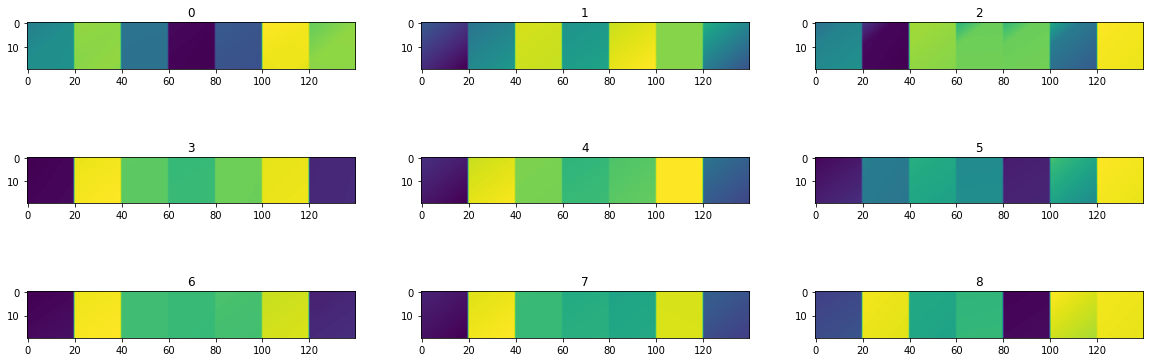

In [35]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

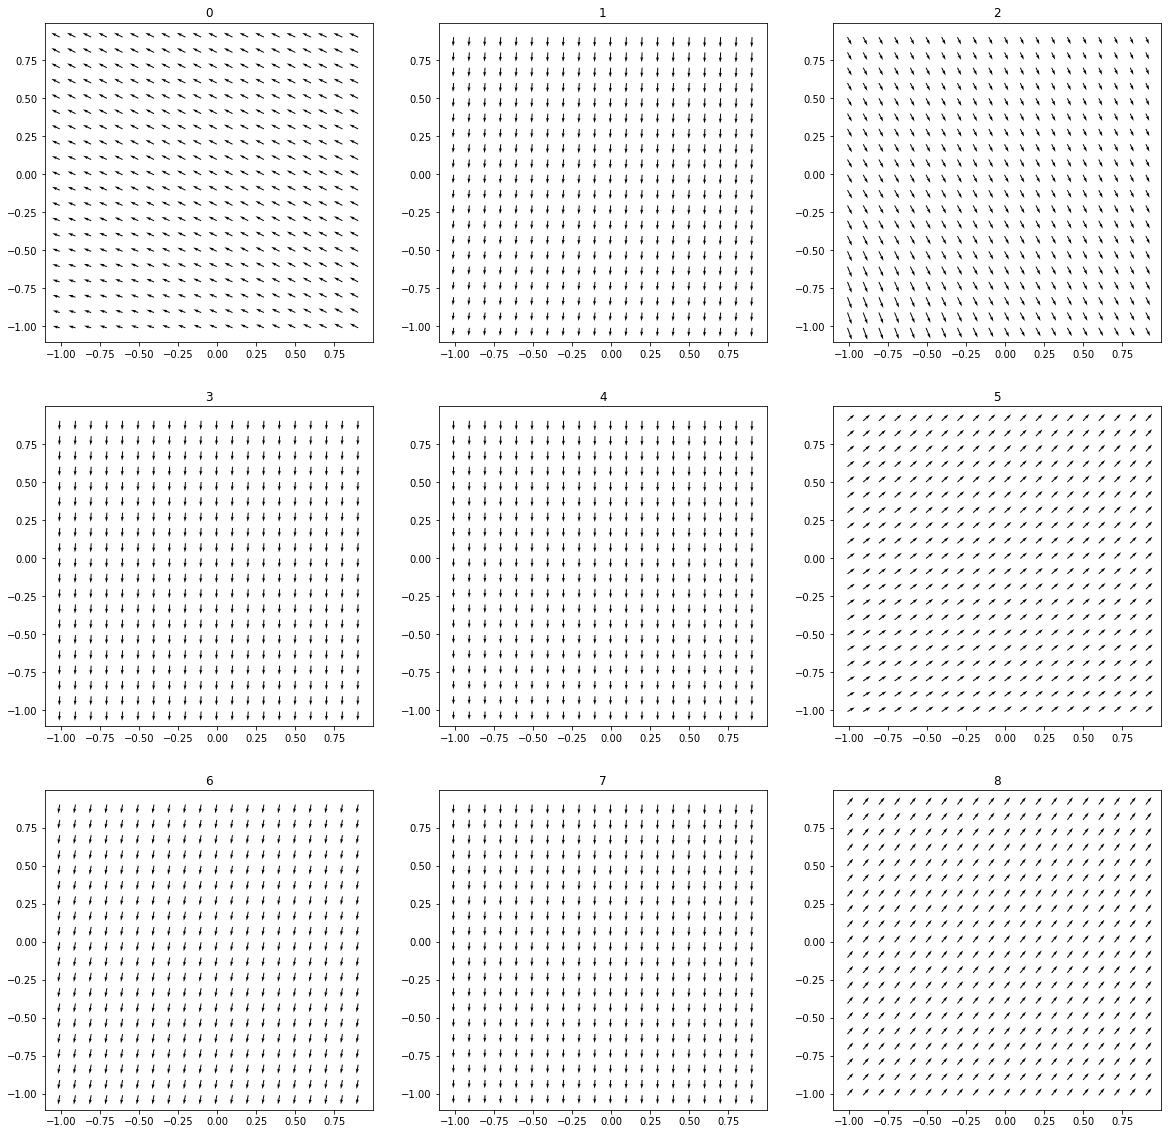

In [36]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)

## AE

In [37]:
decoder = cvae.ConditionalVAE.load_from_checkpoint('checkpoints/ae.ckpt')

In [38]:
decoder

ConditionalVAE(
  (encoder): Sequential(
    (0): Linear(in_features=16, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=8, bias=True)
  )
  (fc_mu): Linear(in_features=10, out_features=2, bias=True)
  (fc_var): Linear(in_features=10, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

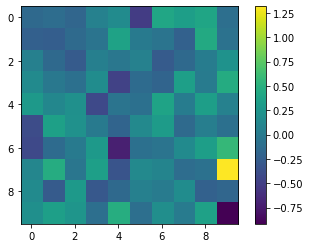

In [39]:
plt.imshow(next(decoder.decoder.parameters()).detach().numpy())
plt.colorbar()
plt.show()

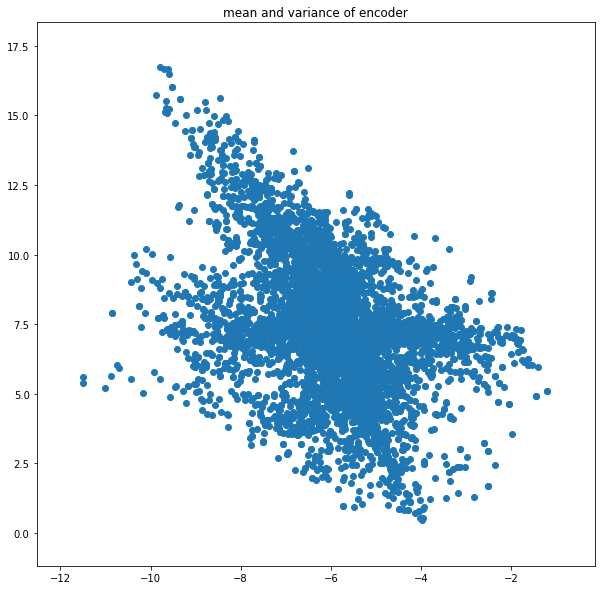

In [40]:
visualize_encoder(decoder)

{'x_min': -11.495883, 'x_max': -1.18019, 'y_min': 0.44658163, 'y_max': 16.716383}


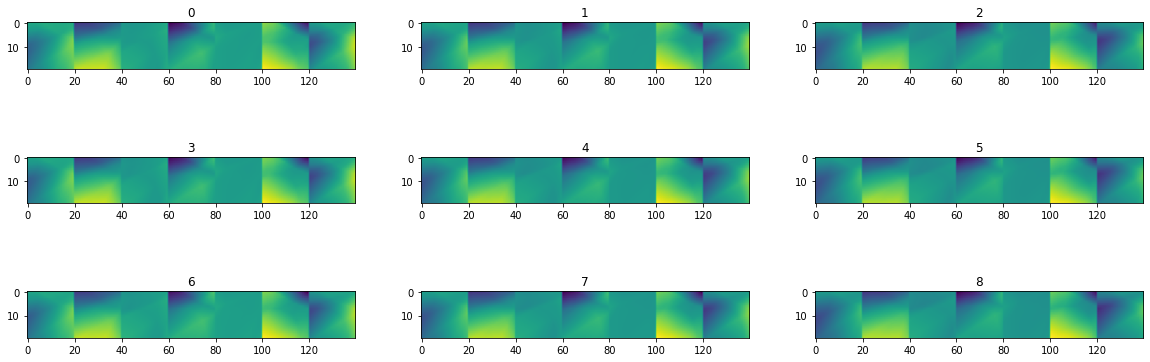

In [41]:
latent_bounds = get_latent_bounds(decoder)
print(latent_bounds)
visualize_decoder(decoder, **latent_bounds)

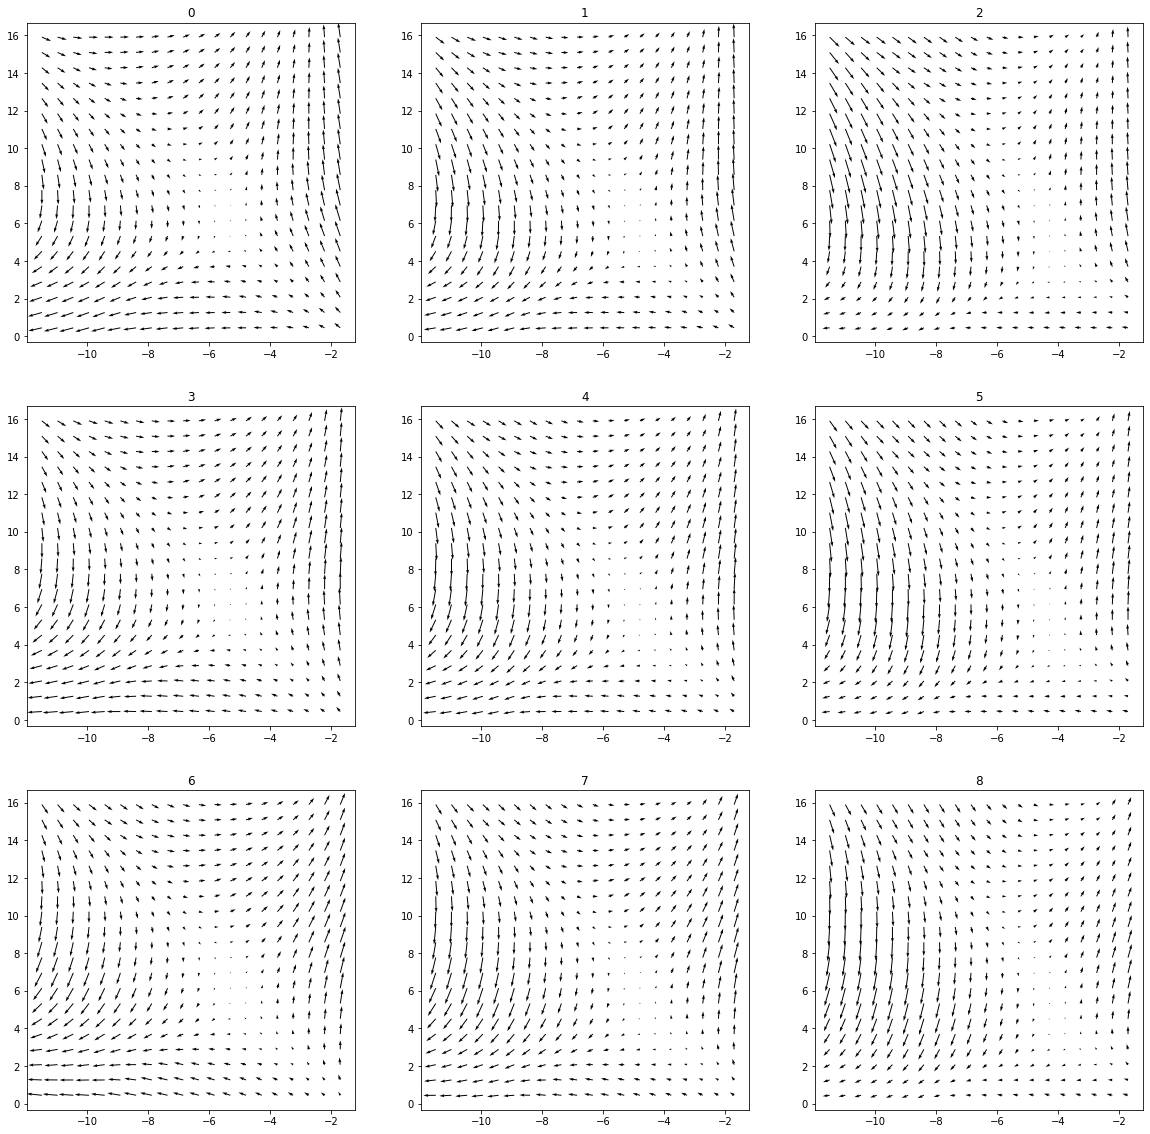

In [42]:
visualize_decoder_forward_kinematics(decoder, **latent_bounds)